In [1]:
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import numpy as np
from nn_classes import SimpleCNN
from data_visualizer import plot_loss_accuracy, plot_confusion_matrix, display_images
from nn_trainer import train_model, test_model
import os

In [2]:
# Set random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# Define image transformations
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # mean & std for MNIST
])

In [4]:
# Create datasets and DataLoader objects
train_dataset_full = MNIST(root='./data', train=True, transform=transform, download=True)
train_dataset, val_dataset = random_split(train_dataset_full, [50000, 10000])
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

batch_size = 64

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

In [5]:
# Define model, loss function and optimizer
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Train model & validate
n_epochs = 10
train_accuracies, train_losses, val_accuracies, val_losses = train_model(model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, optimizer=optimizer, n_epochs=n_epochs)
if os.path.exists("best_model.pth"):
    model.load_state_dict(torch.load("best_model.pth"))
else:
    raise FileNotFoundError("No pre-trained model found.")
test_accuracy, test_loss = test_model(model, test_loader=test_loader, criterion=criterion)

Epoch [1/10], Train loss: 0.1558, Train Acc: 0.9518 | Val Loss: 0.0597, Val Acc: 0.9810
Epoch [2/10], Train loss: 0.0514, Train Acc: 0.9840 | Val Loss: 0.0490, Val Acc: 0.9848
Epoch [3/10], Train loss: 0.0354, Train Acc: 0.9886 | Val Loss: 0.0441, Val Acc: 0.9879
Epoch [4/10], Train loss: 0.0268, Train Acc: 0.9914 | Val Loss: 0.0405, Val Acc: 0.9887
Epoch [5/10], Train loss: 0.0204, Train Acc: 0.9934 | Val Loss: 0.0442, Val Acc: 0.9887
Epoch [6/10], Train loss: 0.0184, Train Acc: 0.9933 | Val Loss: 0.0437, Val Acc: 0.9898
Epoch [7/10], Train loss: 0.0154, Train Acc: 0.9948 | Val Loss: 0.0521, Val Acc: 0.9888
Epoch [8/10], Train loss: 0.0138, Train Acc: 0.9952 | Val Loss: 0.0607, Val Acc: 0.9881
Epoch [9/10], Train loss: 0.0113, Train Acc: 0.9960 | Val Loss: 0.0556, Val Acc: 0.9869
Epoch [10/10], Train loss: 0.0093, Train Acc: 0.9968 | Val Loss: 0.0519, Val Acc: 0.9892
Saved best model with validation accuracy: 0.9898
Training complete. Total training time: 11 minutes 27.5 seconds
Test 

In [7]:
# Predict n_pred values
n_pred = len(test_dataset)
model.eval()
with torch.no_grad():
    sample_images = [test_dataset[i][0] for i in range(n_pred)]
    true_labels = [test_dataset[i][1] for i in range(n_pred)]
    sample_images = torch.stack(sample_images)
    outputs = model(sample_images)
    _, predictions = torch.max(outputs, 1)
predictions = predictions.tolist()

In [8]:
# Get wrong predictions
wrong_predictions = [pred != true for pred, true in zip(predictions, true_labels)]
wrong_indices = [i for i, is_wrong in enumerate(wrong_predictions) if is_wrong]
wrong_guesses = [predictions[i] for i in wrong_indices]
print(f"Total samples: {len(predictions)} | Misclassified: {len(wrong_indices)}")

Total samples: 10000 | Misclassified: 92


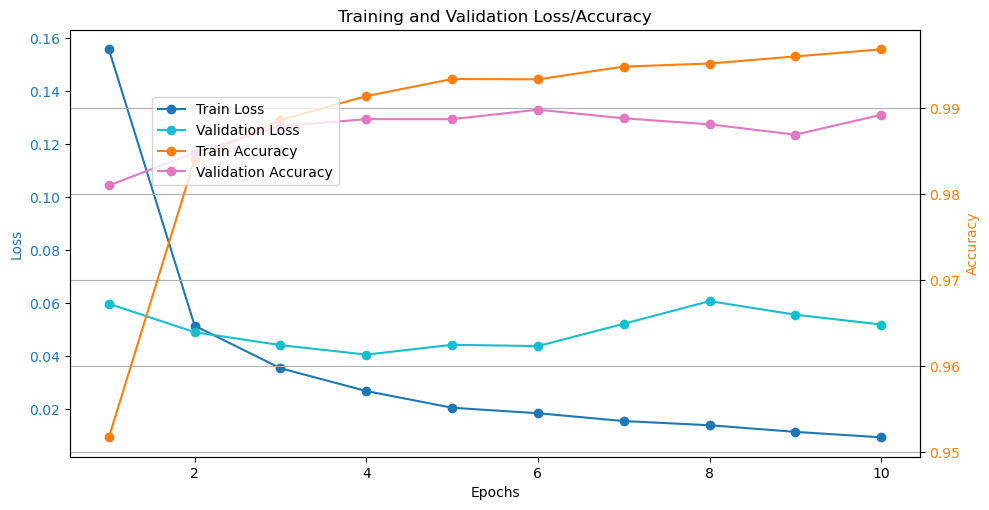

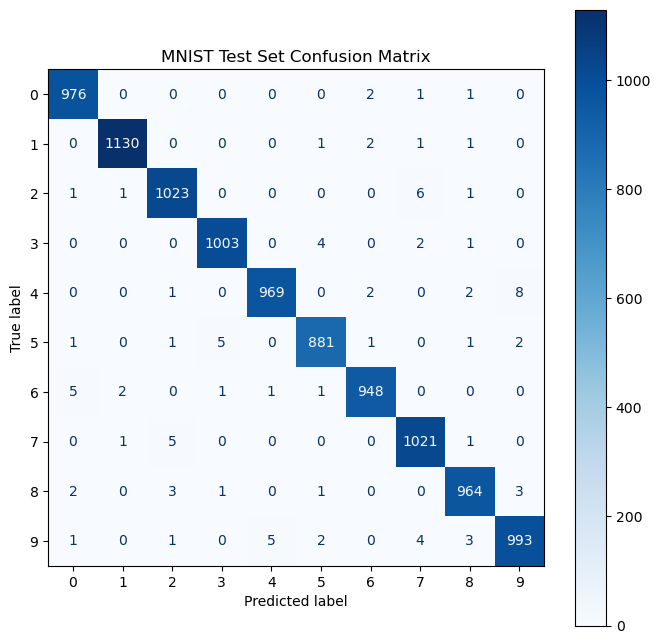

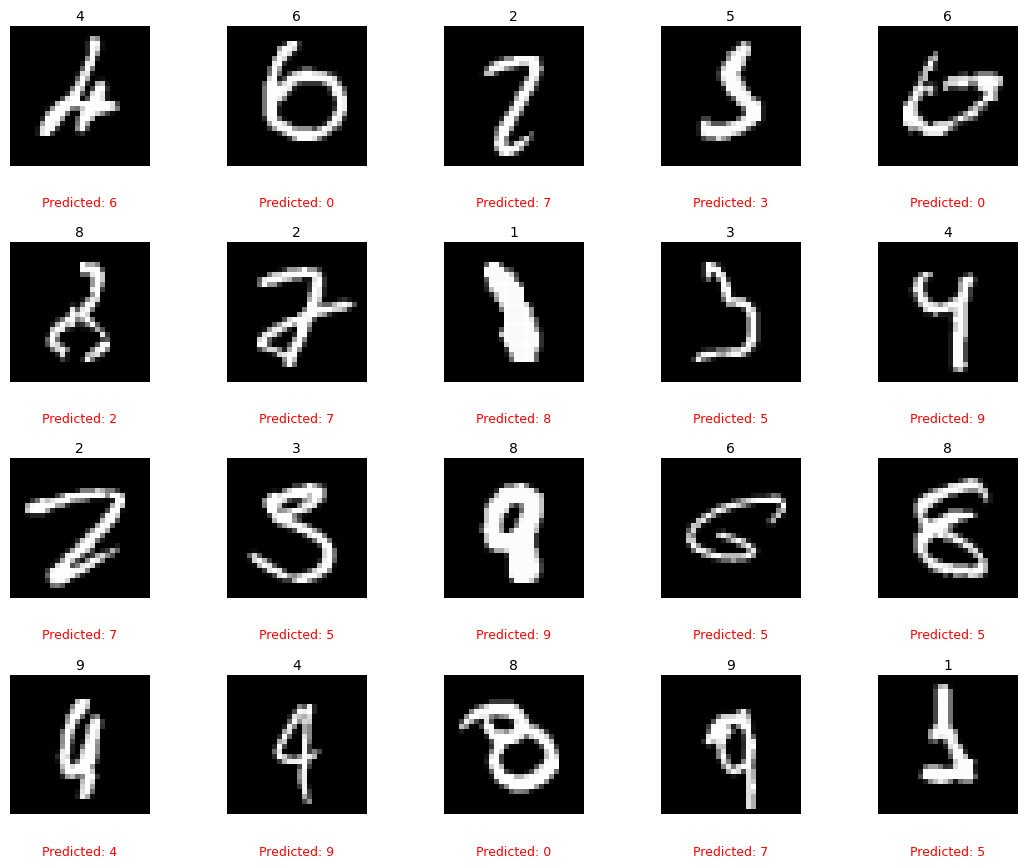

In [9]:
# Visualize results
plot_loss_accuracy(train_losses, val_losses, train_accuracies, val_accuracies)
plot_confusion_matrix(model, test_loader)
display_images([test_dataset[i] for i in wrong_indices[:20]], predictions=wrong_guesses[:20])